### 模型选择、欠拟合和过拟合

In [1]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：

**$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where } \epsilon \sim \mathcal{N}(0, 0.1^2).$$**

In [3]:
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# labels 的维度: (n_train + n_test, )
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)  # scale: 标准差(即分布的宽度)


### 上述代码举例解释

当执行 `np.power(features, np.arange(max_degree).reshape(1, -1))` 这个操作时，它将特征矩阵 `features` 中的每个元素分别提升到对应的 0 到 `max_degree-1` 次方。这就是特征的多项式展开，其中 `max_degree` 是指定的多项式的最大次数。

接下来来具体解释这两行代码，并通过一个简单的例子来说明：

```python
import numpy as np

# 假设有一些特征
features = np.array([[2], [3], [4]])

# 设置多项式的最大次数
max_degree = 4

# 对特征进行多项式展开
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))

print(poly_features)
```

在这个例子中，`features` 是一个列向量，包含了三个特征值 `[2, 3, 4]`。我们想要将这些特征进行多项式展开，最大次数设置为 `4`。

第一行 `np.power(features, np.arange(max_degree).reshape(1, -1))` 创建了一个矩阵，其中每一行是特征向量的元素分别提升到 0 到 `max_degree-1` 次方：

```
poly_features = [
  [2^0, 2^1, 2^2, 2^3],  # 对应特征 2
  [3^0, 3^1, 3^2, 3^3],  # 对应特征 3
  [4^0, 4^1, 4^2, 4^3]   # 对应特征 4
]
```

然后，循环 `for i in range(max_degree)` 迭代每个次数，并将多项式特征矩阵中的每列除以 `math.gamma(i + 1)`，从而进行归一化。

例子中的 `math.gamma(i + 1)` 就是 `(i + 1)!`，即阶乘，例如 `1! = 1`，`2! = 2`，`3! = 6` 等等。这是为了确保高次项不会过大，以避免在多项式回归中引入不稳定性。

最终的 `poly_features` 矩阵就是经过多项式展开并进行归一化的特征矩阵。这种处理可以帮助确保在多项式回归问题中，不同次数的特征对模型的贡献在尺度上是平衡的。

In [4]:
# 看一下前2个样本
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]
]
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.0768],
         [-0.3932]]),
 tensor([[ 1.0000e+00, -7.6753e-02,  2.9455e-03, -7.5359e-05,  1.4460e-06,
          -2.2197e-08,  2.8395e-10, -3.1134e-12,  2.9871e-14, -2.5474e-16,
           1.9552e-18, -1.3642e-20,  8.7258e-23, -5.1518e-25,  2.8244e-27,
          -1.4452e-29,  6.9328e-32, -3.1301e-34,  1.3347e-36, -5.3916e-39],
         [ 1.0000e+00, -3.9318e-01,  7.7294e-02, -1.0130e-02,  9.9574e-04,
          -7.8300e-05,  5.1310e-06, -2.8820e-07,  1.4164e-08, -6.1878e-10,
           2.4329e-11, -8.6961e-13,  2.8493e-14, -8.6174e-16,  2.4201e-17,
          -6.3436e-19,  1.5589e-20, -3.6053e-22,  7.8752e-24, -1.6297e-25]]),
 tensor([4.7883, 4.1705]))

In [5]:
# 实现一个函数来评估模型在给定数据集上地损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
        return metric[0] / metric[1]

In [6]:
def train(train_features,
          test_features,
          train_labels,
          test_labels,
          num_epochs=400):
    # 定义损失函数为均方误差（MSE），不进行降维操作
    loss = nn.MSELoss(reduction='none')

    # 计算输入特征的维度
    input_shape = train_features.shape[-1]

    # 创建一个线性回归模型，输入维度为 input_shape，输出维度为 1，不使用偏置项
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))

    # 设置小批量的大小，取 10 和训练集标签数量的较小值
    batch_size = min(10, train_labels.shape[0])

    # 创建训练数据迭代器，用于获取小批量的训练数据
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)

    # 创建测试数据迭代器，用于获取小批量的测试数据
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size,
                               is_train=False)

    # 创建随机梯度下降（SGD）优化器，用于更新模型的参数，学习率为 0.01
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)

    # 创建一个可视化工具，用于动态绘制训练和测试损失的变化
    animator = d2l.Animator(xlabel='epoch',
                            ylabel='loss',
                            yscale='log',
                            xlim=[1, num_epochs],
                            ylim=[1e-3, 1e2],
                            legend=['train', 'test'])

    # 开始训练循环，迭代 num_epochs 个epoch
    for epoch in range(num_epochs):
        # 在训练数据上进行一个epoch的训练，更新模型参数
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)

        # 每个 epoch 开始或者每隔 20 个 epoch，计算并记录训练和测试集上的损失
        if epoch == 0 or (epoch + 1) % 20 == 0:
            # 计算训练集和测试集上的损失
            train_loss = evaluate_loss(net, train_iter, loss)
            test_loss = evaluate_loss(net, test_iter, loss)

            # 添加损失值到可视化工具中，用于动态绘制损失变化
            animator.add(epoch + 1, (train_loss, test_loss))

    # 打印训练完成后模型的权重参数
    print('weight:', net[0].weight.data.numpy())


weight: [[ 4.973526   1.302833  -3.3173494  5.329147 ]]


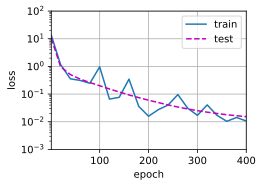

In [7]:
# 三阶多项式函数拟合（正态）
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.8387983 2.743399 ]]


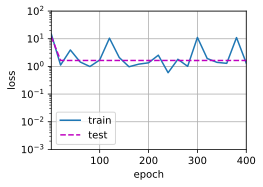

In [8]:
# 线性函数拟合（欠拟合）
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9844813   1.356389   -3.3633506   4.9644027   0.02676672  1.2707491
   0.29125875  0.35872358 -0.16782641 -0.08112708  0.0836923  -0.10596345
   0.19613226  0.19034457 -0.08012114  0.09032015 -0.08014952 -0.08868003
   0.15416259 -0.18401633]]


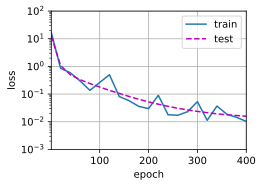

In [9]:
# 高阶多项式函数拟合（过拟合）
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:])